## Step 1: Import Libraries
In this step, we import all the necessary libraries for data fetching, cleaning, analysis, and visualization.

In [3]:
# Import required libraries
import requests
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
# from ipywidgets import interact

# Set Matplotlib inline for Jupyter Notebook
%matplotlib inline


## Step 2: Define Constants and Helper Functions
Here we define constants (like the dataset URL) and helper functions.

### Constants

In [4]:
DATA_URL = "https://data.nasa.gov/resource/y77d-th95.json"


### Helper Functions

In [51]:
def fetch_data(url):
    """
    Fetch JSON data from the provided URL.

    Args:
        url (str): The URL to fetch data from.

    Returns:
        list: A list of dictionaries containing the dataset.
              Returns an empty list if the request fails.
    """
    try:
        response = requests.get(url)
        response.raise_for_status()  # Raise an error for bad HTTP responses
        return response.json()
    except requests.exceptions.RequestException as e:
        print(f"Error fetching data: {e}")
        return []

def clean_data(data):
    """
    Convert JSON data to a Pandas DataFrame and clean it.

    - Handles missing values.
    - Converts columns to appropriate data types.
    - Extracts the year from datetime values.

    Args:
        data (list): A list of dictionaries representing the dataset.

    Returns:
        pd.DataFrame: A cleaned DataFrame with valid `mass` and `year` columns.
                      Returns an empty DataFrame if critical columns are missing.
    """
    # Load data into a DataFrame
    df = pd.DataFrame(data)

    # Ensure critical columns exist in the dataset
    if 'mass' not in df.columns or 'year' not in df.columns:
        print("Critical columns ('mass', 'year') are missing from the dataset.")
        return pd.DataFrame()

    # Handle missing or malformed data
    df['mass'] = pd.to_numeric(df['mass'], errors='coerce')  # Convert mass to float, set invalid values to NaN
    df['year'] = pd.to_datetime(df['year'], errors='coerce')  # Convert year to datetime, set invalid values to NaT

    # Drop rows with missing critical values (mass or year)
    df = df.dropna(subset=['mass', 'year'])

    # Extract only the year part from the datetime column for analysis
    df['year'] = df['year'].dt.year

    return df

def analyze_data(df):
    """
    Analyze the dataset to extract key insights.

    - Counts total entries.
    - Finds the most massive meteorite.
    - Identifies the most frequent year of meteorite landings.

    Args:
        df (pd.DataFrame): The cleaned DataFrame.

    Returns:
        dict: A dictionary containing:
              - total_entries (int): Total number of entries in the dataset.
              - most_massive_name (str): Name of the most massive meteorite.
              - most_massive_mass (float): Mass of the most massive meteorite.
              - most_frequent_year (int): Year with the most meteorite landings.
              - most_frequent_count (int): Number of landings in that year.
    """
    results = {}

    # Total number of entries
    results['total_entries'] = len(df)

    # Most massive meteorite
    most_massive = df.loc[df['mass'].idxmax()]
    results['most_massive_name'] = most_massive['name']
    results['most_massive_mass'] = most_massive['mass']

    # Most frequent year
    most_frequent_year = df['year'].value_counts().idxmax()
    most_frequent_count = df['year'].value_counts().max()
    results['most_frequent_year'] = most_frequent_year
    results['most_frequent_count'] = most_frequent_count

    return results

def visualize_data(df):
    """
    Create visualizations for better understanding of the dataset.

    - Bar chart: Meteorite counts per year.
    - Histogram: Distribution of meteorite masses.
    - Scatter plot: Mass vs. Year.

    Args:
        df (pd.DataFrame): The cleaned DataFrame.

    Saves:
        meteorite_counts_per_year.png: Bar chart showing counts per year.
        meteorite_mass_distribution.png: Histogram showing mass distribution.
        scatter_mass_vs_year.png: Scatter plot of mass vs. year.
    """
    # Bar chart: Meteorite counts per year
    plt.figure(figsize=(12, 6))
    sns.countplot(x='year',
                  data=df,
                  palette='viridis',
                  hue='year',
                  legend=False,
                  order=sorted(df['year'].unique()))
    # Show every 5th year as a label
    years = sorted(df['year'].unique())
    tick_positions = range(0, len(years), 5)
    tick_labels = [years[i] for i in tick_positions]
    plt.xticks(ticks=tick_positions,
               labels=tick_labels,
               rotation=45,
               ha='right')
    plt.title('Meteorite Counts Per Year')
    plt.xlabel('Year')
    plt.ylabel('Count')
    plt.tight_layout()
    plt.show()

    # Histogram: Distribution of meteorite masses (log-scaled)
    plt.figure(figsize=(12, 6))
    # Filter dataset to exclude extreme outliers
    filtered_df = df[df['mass'] <= 100000]
    sns.histplot(filtered_df['mass'], bins=100, kde=True, color='blue')
    # Highlight mean and median with vertical lines
    mean_mass = filtered_df['mass'].mean()
    median_mass = filtered_df['mass'].median()
    plt.axvline(mean_mass, color='red', linestyle='--', label=f'Mean: {mean_mass:.2f}g')
    plt.axvline(median_mass, color='green', linestyle='--', label=f'Median: {median_mass:.2f}g')
    plt.legend()
    plt.xscale('log')
    plt.title('Log-Scaled Distribution of Meteorite Masses (Filtered)')
    plt.xlabel('Mass (log scale)')
    plt.ylabel('Frequency')
    plt.tight_layout()
    plt.show()

    # Scatter plot: Mass vs. Year (log-scaled)
    plt.figure(figsize=(12, 6))
    sns.scatterplot(x='year', y='mass', data=df, alpha=0.7, color='red')
    plt.title('Meteorite Mass vs. Year')
    plt.xlabel('Year')
    plt.ylabel('Mass (grams)')
    plt.yscale("log")
    plt.tight_layout()
    plt.show()


## Step 3: Fetch Data
Fetch raw JSON data from NASA's API and check if it was retrieved successfully.

In [13]:
# Fetch raw data from the API
print("Fetching data...")
raw_data = fetch_data(DATA_URL)

# Check if data was fetched successfully
if raw_data:
    print(f"Successfully fetched {len(raw_data)} records.")
else:
    print("No data was fetched.")


Fetching data...
Successfully fetched 1000 records.


## Step 4: Clean Data
Clean and preprocess the fetched data by handling missing values and converting columns to appropriate types.

In [14]:
# Clean and preprocess the fetched data
print("Cleaning data...")
df = clean_data(raw_data)

# Check if cleaning was successful and display a preview of the DataFrame
if not df.empty:
    print(f"Data cleaned successfully. Total valid records: {len(df)}")
else:
    print("The dataset is empty after cleaning.")

df.head()  # Display first few rows for inspection

# Display summary statistics for key columns (mass and year)
print("\nSummary Statistics:")
display(df[['mass', 'year']].describe())


Cleaning data...
Data cleaned successfully. Total valid records: 960

Summary Statistics:


,mass,year
count,9.600000e+02,960.000000
mean,5.049076e+04,1918.152083
std,7.586692e+05,58.493654
min,1.500000e-01,1688.000000
25%,6.795000e+02,1877.000000
50%,2.835000e+03,1924.000000
75%,1.000000e+04,1964.000000
max,2.300000e+07,2013.000000


## Step 5: Analyze Data
Analyze the cleaned dataset to extract key insights such as total entries, most massive meteorite, and most frequent year.

In [16]:
# Analyze the cleaned dataset for insights
print("Analyzing data...")
results = analyze_data(df)

# Display analysis results in a structured format using a DataFrame
analysis_results = pd.DataFrame({
      "Metric": ["Total Entries", "Most Massive Meteorite", "Mass (grams)", "Most Frequent Year", "Occurrences"],
      "Value": [
          results['total_entries'],
          results['most_massive_name'],
          results['most_massive_mass'],
          results['most_frequent_year'],
          results['most_frequent_count']
      ]
})
display(analysis_results)


Analyzing data...


,Metric,Value
0,Total Entries,960
1,Most Massive Meteorite,Sikhote-Alin
2,Mass (grams),23000000.0
3,Most Frequent Year,1933
4,Occurrences,16


## Step 6: Visualize Data
Create visualizations to better understand patterns in meteorite landings over time and their mass distribution.

Creating visualizations...


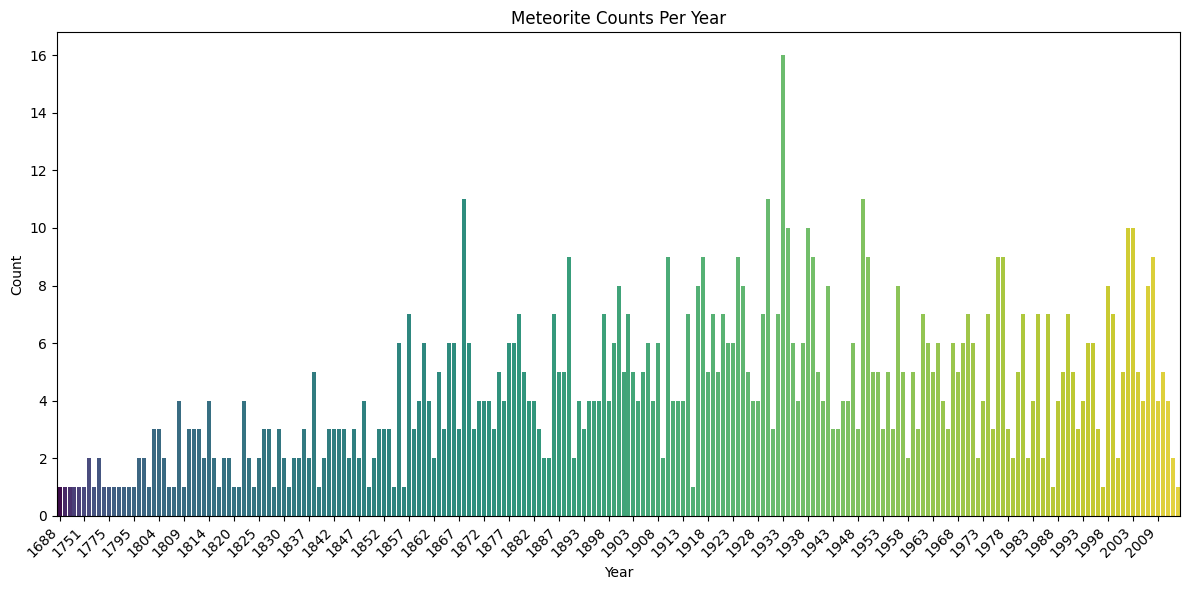

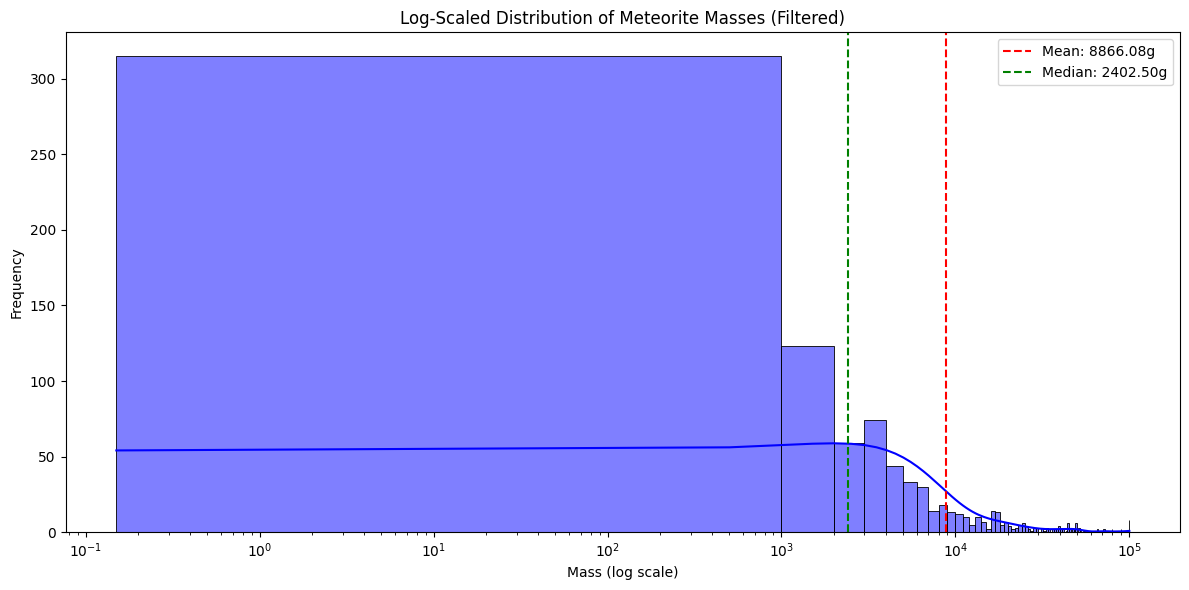

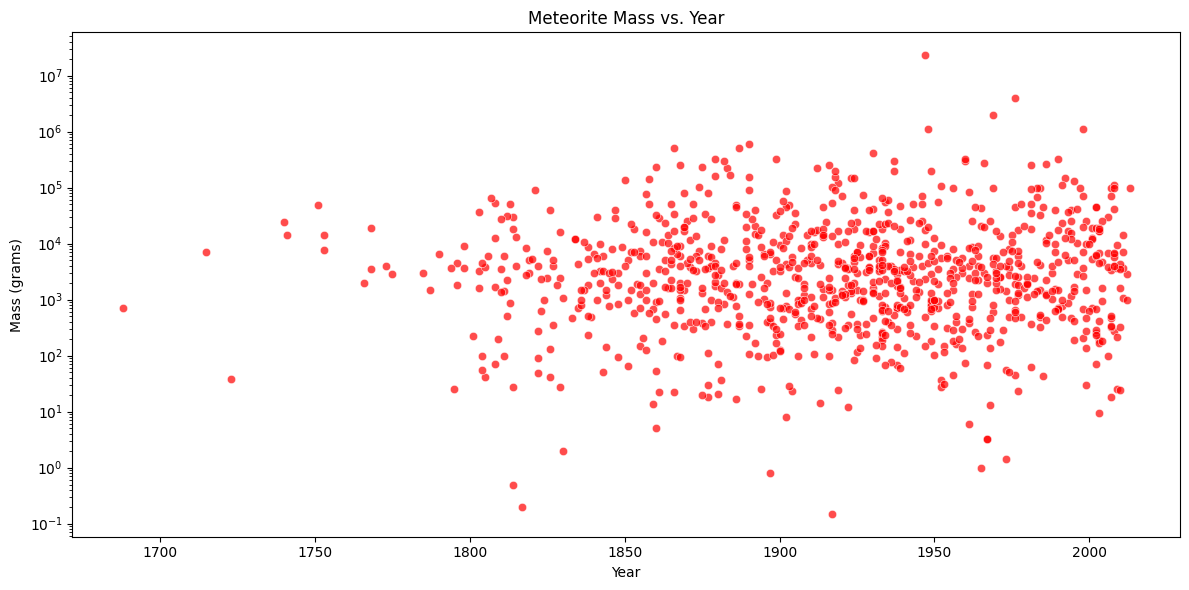

In [52]:
# Visualize the dataset using Seaborn and Matplotlib plots
print("Creating visualizations...")
visualize_data(df)


## Conclusion

- The dataset contains 960 valid meteorite landings after cleaning.
- The most massive meteorite is named "Sikhote-Alin" with a mass of 23000000.0 grams.
- The year with the highest number of meteorite landings is 1933 with 16 occurrences.

Visualizations provide further insights into yearly trends and mass distributions.